# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
TRAIN_DIR = Path('journey-springfield/train')
TEST_DIR = Path('journey-springfield/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [9]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

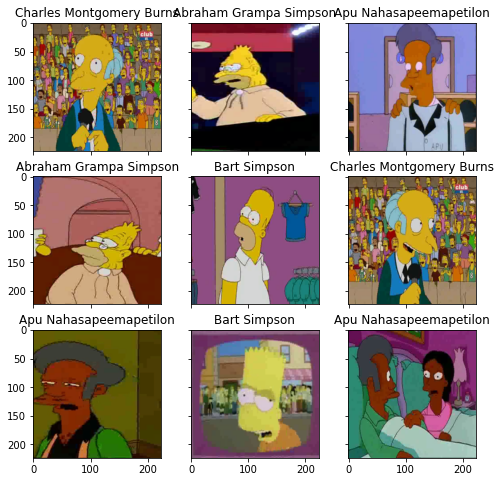

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5
**К базовой архитектуре добавил:**
- два скрытых полносвязных слоя в классификаторе (в части сети, которая отвечает за классификацию);
- пакетную нормализацию после каждого блока свёртки и после каждого скрытого полносвязного слоя;
- слой Dropout с коэффициентом 0.3 на входе в классификатор с целью "научить" классификатор поучать нужную информацию из разных наборов признаков (на выходе из блоков свёртки), получится своего рода ансамбль разных классификаторов, работающих с разным набором признаков
- пробовал оптимизаторы отличные от Adam, но эксперименты показали, что скор у Adam получается наилучший;
- learning rate каждые 4 эпохи уменьшаею в 10 раз.

In [11]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(96 * 5 * 5, 1200),
            nn.ReLU(),
            nn.BatchNorm1d(1200),
            nn.Linear(1200, 600),
            nn.ReLU(),
            nn.BatchNorm1d(600),
            nn.Linear(600, n_classes),
        )
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [13]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [14]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    if val_dataset:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    if val_dataset:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    else:
        log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
#         opt = torch.optim.AdamW(model.parameters())
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.1, patience=2)
#         criterion = nn.CrossEntropyLoss()
        opt = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            if val_dataset:
                val_loss, val_acc = eval_epoch(model, val_loader, criterion)
                history.append((train_loss, train_acc, val_loss, val_acc))
            else:
                history.append((train_loss, train_acc))
#             scheduler.step(train_loss)
            scheduler.step()
            
            pbar_outer.update(1)
            if val_dataset:
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            else:
                tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))
            
    return history

In [15]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [16]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify: {}".format(n_classes))
print(simple_cnn)

we will classify: 42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

Запустим обучение сети.

In [17]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [18]:
%%time
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=12, batch_size=64)


epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]

loss 1.7898252226986076


epoch:   8%|██████▎                                                                    | 1/12 [02:00<22:10, 120.98s/it]


Epoch 001 train_loss: 1.7898 val_loss 1.2220 train_acc 0.5355 val_acc 0.6725
loss 0.9376489447688546


epoch:  17%|████████████▌                                                              | 2/12 [04:01<20:05, 120.53s/it]


Epoch 002 train_loss: 0.9376 val_loss 0.9256 train_acc 0.7327 val_acc 0.7442
loss 0.6063998386779251


epoch:  25%|██████████████████▊                                                        | 3/12 [06:01<18:04, 120.51s/it]


Epoch 003 train_loss: 0.6064 val_loss 0.8214 train_acc 0.8222 val_acc 0.7872
loss 0.4074164659128469


epoch:  33%|█████████████████████████                                                  | 4/12 [08:02<16:05, 120.68s/it]


Epoch 004 train_loss: 0.4074 val_loss 0.7155 train_acc 0.8776 val_acc 0.8187
loss 0.1734871991297642


epoch:  42%|███████████████████████████████▎                                           | 5/12 [10:08<14:17, 122.44s/it]


Epoch 005 train_loss: 0.1735 val_loss 0.5438 train_acc 0.9503 val_acc 0.8672
loss 0.10536758525398963


epoch:  50%|█████████████████████████████████████▌                                     | 6/12 [12:15<12:25, 124.24s/it]


Epoch 006 train_loss: 0.1054 val_loss 0.5289 train_acc 0.9752 val_acc 0.8733
loss 0.07672619993696814


epoch:  58%|███████████████████████████████████████████▊                               | 7/12 [14:18<10:18, 123.67s/it]


Epoch 007 train_loss: 0.0767 val_loss 0.5189 train_acc 0.9853 val_acc 0.8741
loss 0.0628997231725371


epoch:  67%|██████████████████████████████████████████████████                         | 8/12 [16:20<08:13, 123.27s/it]


Epoch 008 train_loss: 0.0629 val_loss 0.5218 train_acc 0.9871 val_acc 0.8762
loss 0.04472541596798147


epoch:  75%|████████████████████████████████████████████████████████▎                  | 9/12 [18:22<06:07, 122.66s/it]


Epoch 009 train_loss: 0.0447 val_loss 0.5160 train_acc 0.9940 val_acc 0.8785
loss 0.0431078679309589


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 10/12 [20:23<04:04, 122.14s/it]


Epoch 010 train_loss: 0.0431 val_loss 0.5175 train_acc 0.9942 val_acc 0.8785
loss 0.04194241740508109


epoch:  92%|███████████████████████████████████████████████████████████████████▊      | 11/12 [22:27<02:02, 122.69s/it]


Epoch 011 train_loss: 0.0419 val_loss 0.5172 train_acc 0.9946 val_acc 0.8779
loss 0.03872289874157455


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 12/12 [24:27<00:00, 122.29s/it]


Epoch 012 train_loss: 0.0387 val_loss 0.5171 train_acc 0.9955 val_acc 0.8794
CPU times: total: 3h 10min 43s
Wall time: 24min 27s


Построим кривые обучения

In [19]:
loss, acc, val_loss, val_acc = zip(*history)

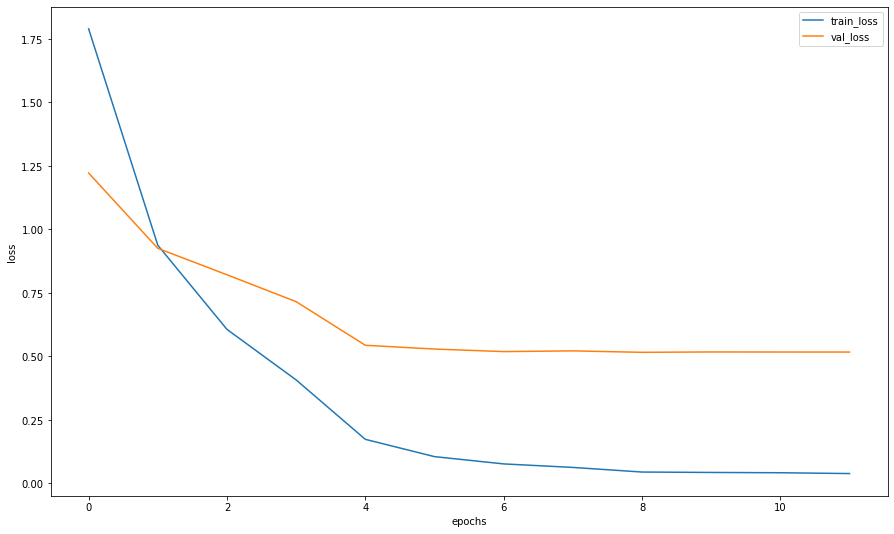

In [20]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Дообучу сеть снова на 12 эпохах, заново уменьшая LR от 0.001 каждые 4 эпохи в 10 раз (в надежде выскочить из локального минимума функции потерь) и **при этом всю выборку (без выделения валидационной части) буду использовать как обучающую** (потенциально это может дать улучшение, но при этом ОТСУТСВУЕТ возможность построить кривые обучения и объективно оценить результат, поэтому оценивать буду по итоговому скору F1-меры)

In [21]:
train_val_dataset = SimpsonsDataset(train_val_files, mode='train')

In [22]:
%%time
train_val_history = train(train_val_dataset, None, model=simple_cnn, epochs=12, batch_size=64)

epoch:   8%|██████▎                                                                    | 1/12 [02:07<23:25, 127.74s/it]

loss 0.4546901915479206

Epoch 001 train_loss: 0.4547 train_acc 0.8711


epoch:  17%|████████████▌                                                              | 2/12 [04:18<21:34, 129.42s/it]

loss 0.3155519032520474

Epoch 002 train_loss: 0.3156 train_acc 0.9018


epoch:  25%|██████████████████▊                                                        | 3/12 [06:28<19:26, 129.65s/it]

loss 0.337223600465387

Epoch 003 train_loss: 0.3372 train_acc 0.8970


epoch:  33%|█████████████████████████                                                  | 4/12 [08:36<17:12, 129.06s/it]

loss 0.12328184977432206

Epoch 004 train_loss: 0.1233 train_acc 0.9619


epoch:  42%|███████████████████████████████▎                                           | 5/12 [10:43<14:59, 128.52s/it]

loss 0.05281556677967502

Epoch 005 train_loss: 0.0528 train_acc 0.9851


epoch:  50%|█████████████████████████████████████▌                                     | 6/12 [12:51<12:49, 128.20s/it]

loss 0.04188249891473743

Epoch 006 train_loss: 0.0419 train_acc 0.9890


epoch:  58%|███████████████████████████████████████████▊                               | 7/12 [14:59<10:40, 128.04s/it]

loss 0.026363541462124947

Epoch 007 train_loss: 0.0264 train_acc 0.9935


epoch:  67%|██████████████████████████████████████████████████                         | 8/12 [17:06<08:31, 127.77s/it]

loss 0.03278515672367512

Epoch 008 train_loss: 0.0328 train_acc 0.9917


epoch:  75%|████████████████████████████████████████████████████████▎                  | 9/12 [19:12<06:21, 127.23s/it]

loss 0.020071684186607677

Epoch 009 train_loss: 0.0201 train_acc 0.9960


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 10/12 [21:19<04:14, 127.22s/it]

loss 0.020428094002965677

Epoch 010 train_loss: 0.0204 train_acc 0.9958


epoch:  92%|███████████████████████████████████████████████████████████████████▊      | 11/12 [23:25<02:06, 126.67s/it]

loss 0.020604476231581754

Epoch 011 train_loss: 0.0206 train_acc 0.9952


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 12/12 [25:32<00:00, 127.73s/it]

loss 0.01968680308164604

Epoch 012 train_loss: 0.0197 train_acc 0.9959
CPU times: total: 3h 19min 52s
Wall time: 25min 32s


### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [24]:
random_characters = int(np.random.uniform(0, 1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [25]:
idxs = list(map(int, np.random.uniform(0, 1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [26]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [27]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = np.array([val_dataset[id][1] for id in idxs])

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

**Значение получилось 1.0 - максимальное теоретически возможное, посмотрим во что это выльется на тестовой выборке на Каггле.**

In [28]:
from sklearn.metrics import f1_score

print(f"f1-score: {f1_score(actual_labels, y_pred, average='weighted')}")

f1-score: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

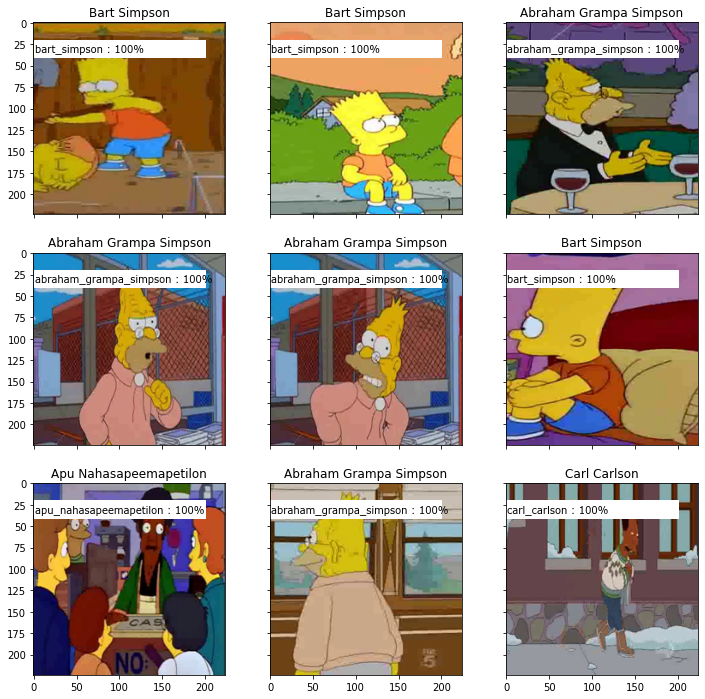

In [29]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))    

    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 20), 200, 20, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("Verdana")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(
        1, 25, predicted_text , horizontalalignment='left', fontproperties=font, verticalalignment='top',
        fontsize=10, color='black'
    )

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

**Анализ показал, что не распознаются в основном те картинки, на которых представлено несколько персонажей, удалю такие файлы из дальнейшего обучения.**

In [30]:
def files_without_unrecognizable(model, dataset, files) -> list:
    model.eval()
    batch_size = 64
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    recognizable_indices = None
    
    for path_and_data in zip(files, loader):
        inputs = path_and_data[1][0].to(DEVICE)
        labels = path_and_data[1][1].to(DEVICE)

        with torch.set_grad_enabled(False):
            preds = torch.argmax(model(inputs), 1)
        
        if recognizable_indices is None:
            recognizable_indices = preds == labels.data
        else:
            recognizable_indices = torch.cat((recognizable_indices, preds == labels.data))
        
    return np.array(files)[recognizable_indices.cpu().numpy()]


recognizable_files = files_without_unrecognizable(simple_cnn, train_val_dataset, train_val_files)

In [31]:
len(train_val_files), len(recognizable_files)

(20933, 20931)

**Итак, есть новый набор обучающих данных (из которого удалены картинки с несколькими персонажами), поэтому предыдущая модель уже не соответствует новому набору обучающих данных. Обучу новую (чистую) модель с нуля на новом наборе данных (без выделения валидационной части для того, чтобы обучающих данных было больше) на 24 эпохах, отправлю предсказания на Каггл и полученный результат будет финальным.**

In [32]:
cleared_dataset = SimpsonsDataset(recognizable_files, mode='train')
cleared_train_loader = DataLoader(cleared_dataset, batch_size=64, shuffle=True)
final_cnn_model = SimpleCnn(n_classes).to(DEVICE)

In [33]:
%%time
final_train_history = train(cleared_dataset, None, model=final_cnn_model, epochs=24, batch_size=64)

epoch:   4%|███▏                                                                       | 1/24 [02:07<48:56, 127.68s/it]

loss 1.5853074748097702

Epoch 001 train_loss: 1.5853 train_acc 0.5844


epoch:   8%|██████▎                                                                    | 2/24 [04:14<46:44, 127.46s/it]

loss 0.8150107191703738

Epoch 002 train_loss: 0.8150 train_acc 0.7761


epoch:  12%|█████████▍                                                                 | 3/24 [06:22<44:37, 127.51s/it]

loss 0.5169527920545084

Epoch 003 train_loss: 0.5170 train_acc 0.8528


epoch:  17%|████████████▌                                                              | 4/24 [08:29<42:25, 127.25s/it]

loss 0.3993867241210303

Epoch 004 train_loss: 0.3994 train_acc 0.8815


epoch:  21%|███████████████▋                                                           | 5/24 [10:37<40:20, 127.38s/it]

loss 0.16745415937199445

Epoch 005 train_loss: 0.1675 train_acc 0.9531


epoch:  25%|██████████████████▊                                                        | 6/24 [12:43<38:04, 126.92s/it]

loss 0.10655487726765682

Epoch 006 train_loss: 0.1066 train_acc 0.9737


epoch:  29%|█████████████████████▉                                                     | 7/24 [14:51<36:08, 127.56s/it]

loss 0.09653055839307115

Epoch 007 train_loss: 0.0965 train_acc 0.9757


epoch:  33%|█████████████████████████                                                  | 8/24 [16:59<34:03, 127.71s/it]

loss 0.07571859847383865

Epoch 008 train_loss: 0.0757 train_acc 0.9822


epoch:  38%|████████████████████████████▏                                              | 9/24 [19:06<31:49, 127.31s/it]

loss 0.05336072001161099

Epoch 009 train_loss: 0.0534 train_acc 0.9905


epoch:  42%|██████████████████████████████▊                                           | 10/24 [21:13<29:42, 127.31s/it]

loss 0.05203100904095481

Epoch 010 train_loss: 0.0520 train_acc 0.9890


epoch:  46%|█████████████████████████████████▉                                        | 11/24 [23:19<27:29, 126.89s/it]

loss 0.050641329922749334

Epoch 011 train_loss: 0.0506 train_acc 0.9899


epoch:  50%|█████████████████████████████████████                                     | 12/24 [25:26<25:21, 126.83s/it]

loss 0.048995075343268114

Epoch 012 train_loss: 0.0490 train_acc 0.9904


epoch:  54%|████████████████████████████████████████                                  | 13/24 [27:34<23:20, 127.28s/it]

loss 0.0486371860952488

Epoch 013 train_loss: 0.0486 train_acc 0.9899


epoch:  58%|███████████████████████████████████████████▏                              | 14/24 [29:41<21:12, 127.29s/it]

loss 0.04790142910387437

Epoch 014 train_loss: 0.0479 train_acc 0.9909


epoch:  62%|██████████████████████████████████████████████▎                           | 15/24 [31:48<19:02, 126.93s/it]

loss 0.04721661240124428

Epoch 015 train_loss: 0.0472 train_acc 0.9913


epoch:  67%|█████████████████████████████████████████████████▎                        | 16/24 [33:54<16:54, 126.84s/it]

loss 0.047182758783564836

Epoch 016 train_loss: 0.0472 train_acc 0.9911


epoch:  71%|████████████████████████████████████████████████████▍                     | 17/24 [36:02<14:49, 127.11s/it]

loss 0.04657910483080854

Epoch 017 train_loss: 0.0466 train_acc 0.9910


epoch:  75%|███████████████████████████████████████████████████████▌                  | 18/24 [38:10<12:43, 127.30s/it]

loss 0.04721852181194835

Epoch 018 train_loss: 0.0472 train_acc 0.9903


epoch:  79%|██████████████████████████████████████████████████████████▌               | 19/24 [40:16<10:35, 127.05s/it]

loss 0.04754344245262195

Epoch 019 train_loss: 0.0475 train_acc 0.9907


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 20/24 [42:25<08:29, 127.46s/it]

loss 0.04665557353069742

Epoch 020 train_loss: 0.0467 train_acc 0.9903


epoch:  88%|████████████████████████████████████████████████████████████████▊         | 21/24 [44:32<06:22, 127.36s/it]

loss 0.047055931159311025

Epoch 021 train_loss: 0.0471 train_acc 0.9914


epoch:  92%|███████████████████████████████████████████████████████████████████▊      | 22/24 [46:39<04:14, 127.38s/it]

loss 0.04707201795060638

Epoch 022 train_loss: 0.0471 train_acc 0.9909


epoch:  96%|██████████████████████████████████████████████████████████████████████▉   | 23/24 [48:47<02:07, 127.39s/it]

loss 0.04802024920194833

Epoch 023 train_loss: 0.0480 train_acc 0.9903


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 24/24 [50:53<00:00, 127.24s/it]

loss 0.047326799451850636

Epoch 024 train_loss: 0.0473 train_acc 0.9908
CPU times: total: 6h 36min 44s
Wall time: 50min 53s


### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [34]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(final_cnn_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [35]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [36]:
my_submit.shape, len(test_filenames), len(preds)

((991, 2), 991, 991)

In [37]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)
my_submit["Id"] = test_filenames
my_submit["Expected"] = preds
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [38]:
my_submit.to_csv("my_submit.csv", index=False)

# Итоговый результат на Каггл: f1-score = 0.99787

Веса полученных в рамках данной работы моделей, сохраню в файлы.

In [41]:
torch.save(final_cnn_model.state_dict(), "homework(final_cnn).model")
torch.save(simple_cnn.state_dict(), "homework(simple_cnn).model")

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
